## Image Captioning - Without Attention

In [1]:
import os
from pathlib import Path
#import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
#from PIL import Image
from collections import Counter
import sys
import random
from nltk.translate.bleu_score import sentence_bleu

#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split

#Vision
import torchvision.transforms as T
#import torchvision.models as models

#Torchtext
#import torchtext; torchtext.disable_torchtext_deprecation_warning() #supress warning
from torchtext.vocab import vocab
#from torchtext.data.utils import get_tokenizer


import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SH2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

For reproducibility:

In [2]:
def set_seed(seed):
    random.seed(seed)  #Python random module
    np.random.seed(seed)  #NumPy random module
    torch.manual_seed(seed)  #PyTorch CPU
    torch.cuda.manual_seed(seed)  #PyTorch GPU
    torch.cuda.manual_seed_all(seed)  #Multi-GPU setups
    torch.backends.cudnn.deterministic = True  #Deterministic behavior
    torch.backends.cudnn.benchmark = False  #Reproducibility

set_seed(46)

In [3]:
#Run if needed
# with zipfile.ZipFile('data/archive.zip') as z_temp:
#     z_temp.extractall(path='data/')

Check path to the image files and caption file:

In [4]:
current_dir = Path.cwd()

if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

if project_root not in sys.path:
    sys.path.append(str(project_root))

captions_path = project_root / 'data' / 'flickr30k_images' / 'results.csv'
single_captions_path = project_root / 'data' / 'flickr30k_images' / 'single_captions_results.csv'
image_dir = project_root  / 'data' / 'flickr30k_images' / 'flickr30k_images'
image_paths = list(image_dir.glob('*.jpg'))

if captions_path.exists():
    print("Caption path exists")
else:
    print("Caption path does not exist")

if image_dir.exists() and image_dir.is_dir():
    print("Image directory exists")
    
    if image_paths:
        print(f"Found {len(image_paths)} images in the directory.")
    else:
        print("No images found in the directory.")
else:
    print("Image directory does not exist")


Caption path exists
Image directory exists
Found 31783 images in the directory.


Check caption.txt file and get the random raws (7 samples) from it

In [5]:
image_captions = pd.read_csv(captions_path, sep='|')
image_captions.columns = image_captions.columns.str.strip()
image_captions.sample(7)

image_name comment_number  \
68478   3382777250.jpg              3   
11402    170525554.jpg              2   
138363  5812770731.jpg              3   
27114   2385034500.jpg              4   
65696   3328380165.jpg              1   
145877  6839984356.jpg              2   
100312  4467634558.jpg              2   

                                                  comment  
68478    A child in a striped shirt is standing in fro...  
11402    A man in black shirt is taking pictures in a ...  
138363   A young female baseball player slides to home...  
27114              Bikers ride down a busy rural street .  
65696    A man in sunglasses is sitting on top of a pl...  
145877   A youth wearing yellow sits on a wall holding...  
100312   Three children pose for a photograph by a rock .

In [6]:
#Handeling device selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Using en_core_web_lg to built vocabulary for our captions. WE are also adding special tokens UNK_TOKEN = 'unk', PAD_TOKEN = 'pad', SOS_TOKEN = 'sos', EOS_TOKEN = 'eos' to our vocabulary:

In [7]:
from src.vocab_builder import VocabularyBuilder

#Replace non-string values with empty string
image_captions['comment'] = image_captions['comment'].apply(lambda x: x if isinstance(x, str) else '')
text_lines = image_captions['comment'].tolist()

if Path.cwd().name == 'notebooks':
    os.chdir("..")

#Uncomment or comment if you want to load or build/save
vocab_builder = VocabularyBuilder(min_freq=2, save_path='./saved_model/vocab_full.pth', special_token=True)
#vocab = vocab_builder.build_vocab(text_lines)
vocab = vocab_builder.load_vocab(device)


In [8]:
words = vocab.get_itos()
#print("Words in our vocab:", words)

vocab_length = len(vocab)
print(f"Total number of words in vocab: {vocab_length}")

Total number of words in vocab: 12102


Creating our dataset instance:

In [9]:
from src.image_caption_dataset import ImageCaptionDataset

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

transforms = T.Compose([
    T.Resize((224, 224)), 
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


flickr_dataset =  ImageCaptionDataset(
    image_paths = image_paths,
    captions = captions_path,
    vocabulary_builder=vocab_builder,
    transform = transforms
)

In [10]:
max_sentence_length = 78

Normalized Image:


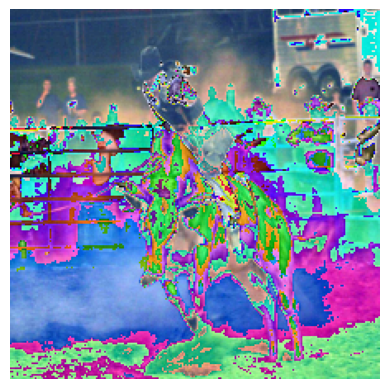

Denormalized Image:


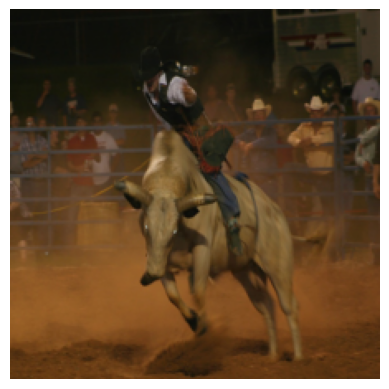

tensor([   2,   31,   32,   70,  911,  860,   50,   18, 5429,  778,   70,  527,
         710,   31, 3697,    3])
Caption :
<sos> a man is being thrown from the bull he is riding during a rodeo <eos>


In [11]:
from src.utils import display_image

img, ids, cap_text = flickr_dataset[10366]
print("Normalized Image:")
display_image(img, denormalize=False)
print("Denormalized Image:")
display_image(img, denormalize=True, mean=mean, std=std)
print(ids)
print('Caption :')
print(vocab_builder.token_ids_to_caption(ids))

Defining dataloader for our dataset and also split dataset into train and test sets (80% train, 20% test)

In [12]:
train_size = int(0.91 * len(flickr_dataset))
val_size = int(0.045 * len(flickr_dataset))
test_size = len(flickr_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    flickr_dataset, [train_size, val_size, test_size]
)

In [13]:
print(f"Number of training samples: {train_size}")
print(f"Number of validation samples: {val_size}")
print(f"Number of test samples: {test_size}")


Number of training samples: 144611
Number of validation samples: 7151
Number of test samples: 7152


In [14]:
from src.batch_caption_collator import BatchCaptionCollator

pad_idx = vocab_builder.vocabulary['<pad>']
batch_size = 256
num_workers = 4
prefetch_factor = 4

collator = BatchCaptionCollator(pad_idx=pad_idx, max_len=max_sentence_length, batch_first=True)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)


## LSTM Without Attention

In [15]:
vocab_size = len(vocab_builder.vocabulary)

emb_size = 300
attn_size = 256
drop_prob = 0.3
enc_hidden_size = 2048
dec_hidden_size = 1024

learning_rate = 1e-3
num_epochs = 100
print_every = 400

weight_decay = 1e-5

backbone="resnet50"  #"efficientnet"

transformation=None
#transformation="conv2d"


save_dir = "saved_model"

In [16]:
from src.models.encoderdecoder import EncoderDecoder

model_NoAttention = EncoderDecoder(
    emb_size=emb_size,
    vocab_size=vocab_size,
    attn_size=attn_size,
    enc_hidden_size=enc_hidden_size,
    dec_hidden_size=dec_hidden_size,
    drop_prob=drop_prob,
    device=device,
    use_attention=False,
    transformation=transformation
)


criterion = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
optimizer = optim.Adam(model_NoAttention.parameters(), lr = learning_rate, weight_decay=weight_decay)

In [17]:
from src.utils import EarlyStopping

earlystopping_patience = 4

LR_patience = 2
LR_factor = 0.1


early_stopping = EarlyStopping(patience=earlystopping_patience, min_delta=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_factor, patience=LR_patience, verbose=True)

Epoch: 1, Batch: 400, Training Loss: 3.57555


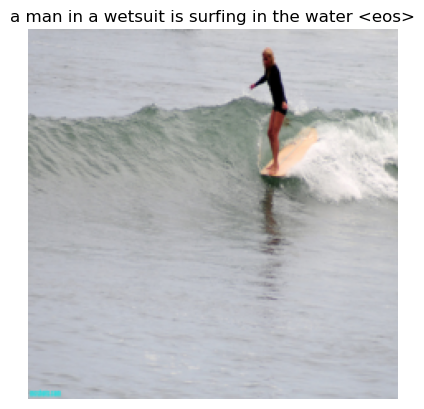

Epoch 1/100 - Train Loss: 3.8657, Val Loss: 3.3129, BLEU: 0.0555, ROUGE-1 Precision: 0.3153, ROUGE-1 Recall: 0.3267, ROUGE-1 F1: 0.3060, ROUGE-2 Precision: 0.0988, ROUGE-2 Recall: 0.1014, ROUGE-2 F1: 0.0950, ROUGE-L Precision: 0.2860, ROUGE-L Recall: 0.3002, ROUGE-L F1: 0.2793
Saved checkpoint for epoch 1 at saved_model\LSTM_without_Attention_resnet50_None_epoch_1.pth.gz
Epoch: 2, Batch: 400, Training Loss: 3.10155


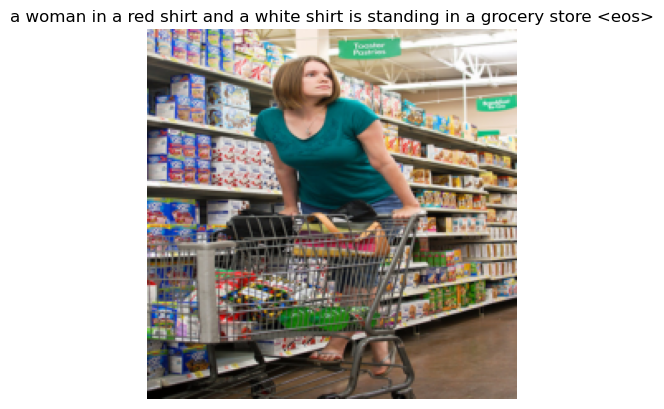

Epoch 2/100 - Train Loss: 3.1617, Val Loss: 3.0870, BLEU: 0.0631, ROUGE-1 Precision: 0.3483, ROUGE-1 Recall: 0.3306, ROUGE-1 F1: 0.3230, ROUGE-2 Precision: 0.1126, ROUGE-2 Recall: 0.1060, ROUGE-2 F1: 0.1034, ROUGE-L Precision: 0.3177, ROUGE-L Recall: 0.3048, ROUGE-L F1: 0.2962
Saved checkpoint for epoch 2 at saved_model\LSTM_without_Attention_resnet50_None_epoch_2.pth.gz
Epoch: 3, Batch: 400, Training Loss: 3.01266


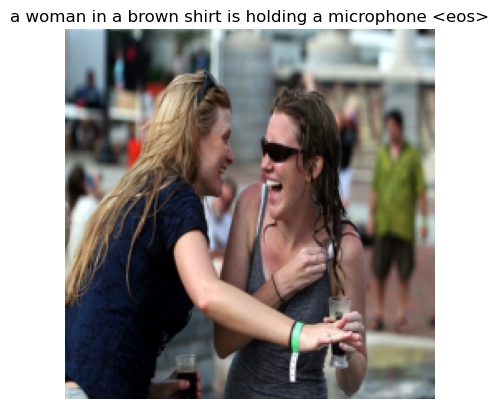

Epoch 3/100 - Train Loss: 2.9449, Val Loss: 2.9723, BLEU: 0.0670, ROUGE-1 Precision: 0.3594, ROUGE-1 Recall: 0.3416, ROUGE-1 F1: 0.3350, ROUGE-2 Precision: 0.1179, ROUGE-2 Recall: 0.1107, ROUGE-2 F1: 0.1087, ROUGE-L Precision: 0.3256, ROUGE-L Recall: 0.3127, ROUGE-L F1: 0.3051
Saved checkpoint for epoch 3 at saved_model\LSTM_without_Attention_resnet50_None_epoch_3.pth.gz
Epoch: 4, Batch: 400, Training Loss: 2.67869


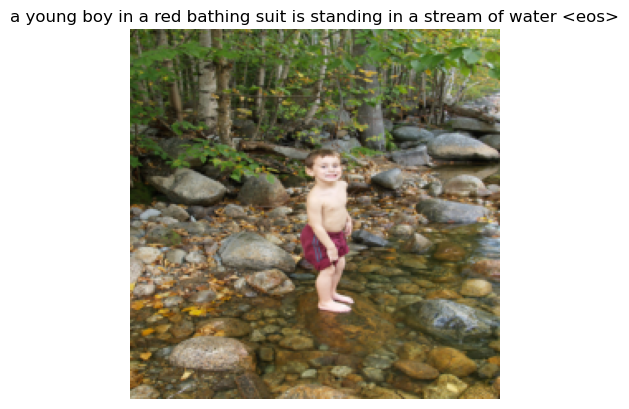

Epoch 4/100 - Train Loss: 2.8039, Val Loss: 2.9008, BLEU: 0.0701, ROUGE-1 Precision: 0.3628, ROUGE-1 Recall: 0.3461, ROUGE-1 F1: 0.3381, ROUGE-2 Precision: 0.1231, ROUGE-2 Recall: 0.1165, ROUGE-2 F1: 0.1137, ROUGE-L Precision: 0.3316, ROUGE-L Recall: 0.3190, ROUGE-L F1: 0.3104
Saved checkpoint for epoch 4 at saved_model\LSTM_without_Attention_resnet50_None_epoch_4.pth.gz
Epoch: 5, Batch: 400, Training Loss: 2.59309


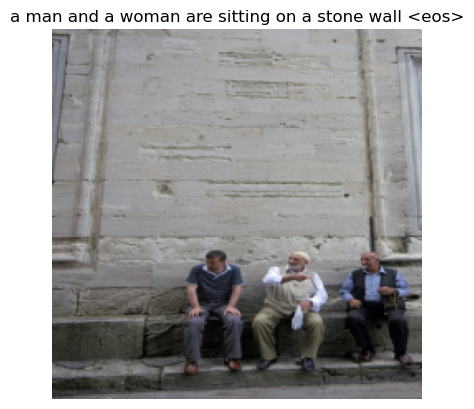

Epoch 5/100 - Train Loss: 2.6951, Val Loss: 2.8619, BLEU: 0.0722, ROUGE-1 Precision: 0.3730, ROUGE-1 Recall: 0.3487, ROUGE-1 F1: 0.3440, ROUGE-2 Precision: 0.1274, ROUGE-2 Recall: 0.1170, ROUGE-2 F1: 0.1158, ROUGE-L Precision: 0.3394, ROUGE-L Recall: 0.3201, ROUGE-L F1: 0.3144
Saved checkpoint for epoch 5 at saved_model\LSTM_without_Attention_resnet50_None_epoch_5.pth.gz
Epoch: 6, Batch: 400, Training Loss: 2.57472


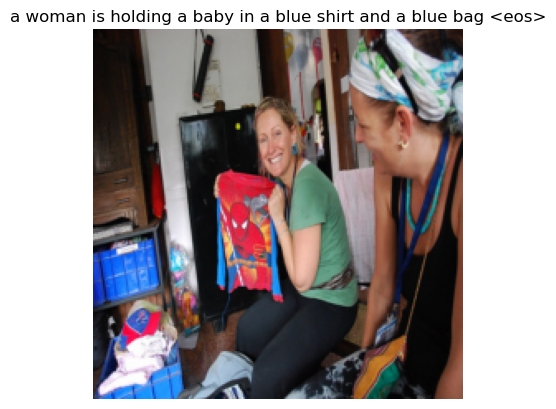

Epoch 6/100 - Train Loss: 2.6059, Val Loss: 2.8257, BLEU: 0.0738, ROUGE-1 Precision: 0.3795, ROUGE-1 Recall: 0.3583, ROUGE-1 F1: 0.3516, ROUGE-2 Precision: 0.1315, ROUGE-2 Recall: 0.1222, ROUGE-2 F1: 0.1202, ROUGE-L Precision: 0.3446, ROUGE-L Recall: 0.3280, ROUGE-L F1: 0.3205
Saved checkpoint for epoch 6 at saved_model\LSTM_without_Attention_resnet50_None_epoch_6.pth.gz
Epoch: 7, Batch: 400, Training Loss: 2.54999


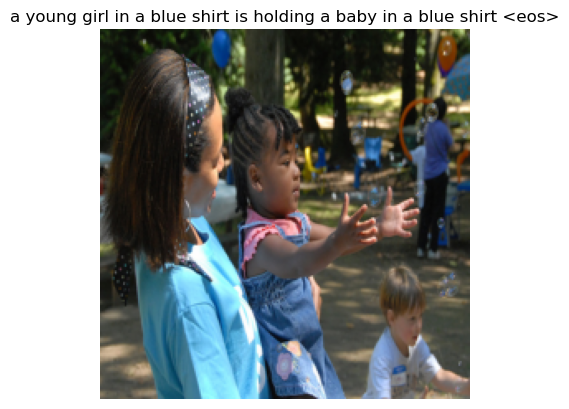

Epoch 7/100 - Train Loss: 2.5277, Val Loss: 2.8028, BLEU: 0.0730, ROUGE-1 Precision: 0.3970, ROUGE-1 Recall: 0.3553, ROUGE-1 F1: 0.3590, ROUGE-2 Precision: 0.1400, ROUGE-2 Recall: 0.1238, ROUGE-2 F1: 0.1251, ROUGE-L Precision: 0.3628, ROUGE-L Recall: 0.3279, ROUGE-L F1: 0.3297
Saved checkpoint for epoch 7 at saved_model\LSTM_without_Attention_resnet50_None_epoch_7.pth.gz
Epoch: 8, Batch: 400, Training Loss: 2.53407


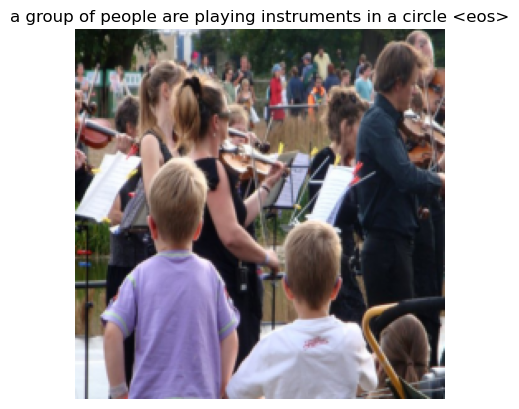

Epoch 8/100 - Train Loss: 2.4591, Val Loss: 2.7888, BLEU: 0.0744, ROUGE-1 Precision: 0.3688, ROUGE-1 Recall: 0.3737, ROUGE-1 F1: 0.3539, ROUGE-2 Precision: 0.1290, ROUGE-2 Recall: 0.1298, ROUGE-2 F1: 0.1228, ROUGE-L Precision: 0.3343, ROUGE-L Recall: 0.3416, ROUGE-L F1: 0.3221
Saved checkpoint for epoch 8 at saved_model\LSTM_without_Attention_resnet50_None_epoch_8.pth.gz
Epoch: 9, Batch: 400, Training Loss: 2.31661


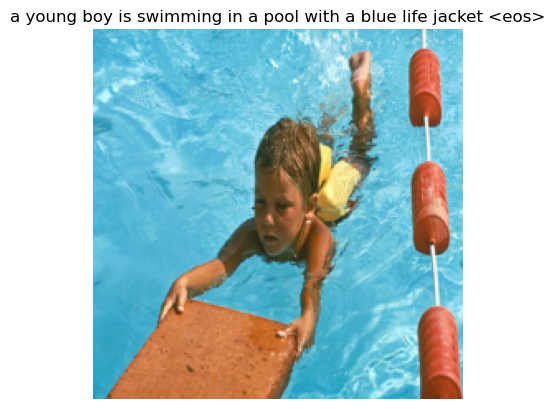

Epoch 9/100 - Train Loss: 2.3978, Val Loss: 2.7743, BLEU: 0.0779, ROUGE-1 Precision: 0.4036, ROUGE-1 Recall: 0.3639, ROUGE-1 F1: 0.3661, ROUGE-2 Precision: 0.1460, ROUGE-2 Recall: 0.1301, ROUGE-2 F1: 0.1311, ROUGE-L Precision: 0.3682, ROUGE-L Recall: 0.3346, ROUGE-L F1: 0.3353
Saved checkpoint for epoch 9 at saved_model\LSTM_without_Attention_resnet50_None_epoch_9.pth.gz
Epoch: 10, Batch: 400, Training Loss: 2.46131


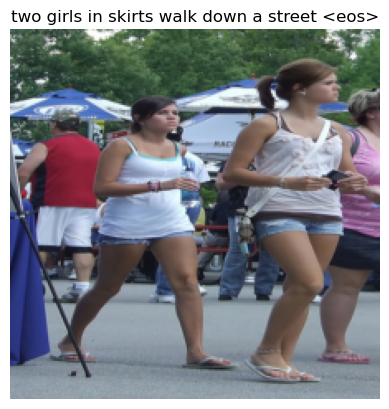

Epoch 10/100 - Train Loss: 2.3410, Val Loss: 2.7626, BLEU: 0.0794, ROUGE-1 Precision: 0.3882, ROUGE-1 Recall: 0.3738, ROUGE-1 F1: 0.3634, ROUGE-2 Precision: 0.1401, ROUGE-2 Recall: 0.1329, ROUGE-2 F1: 0.1295, ROUGE-L Precision: 0.3524, ROUGE-L Recall: 0.3421, ROUGE-L F1: 0.3313
Saved checkpoint for epoch 10 at saved_model\LSTM_without_Attention_resnet50_None_epoch_10.pth.gz
Epoch: 11, Batch: 400, Training Loss: 2.36965


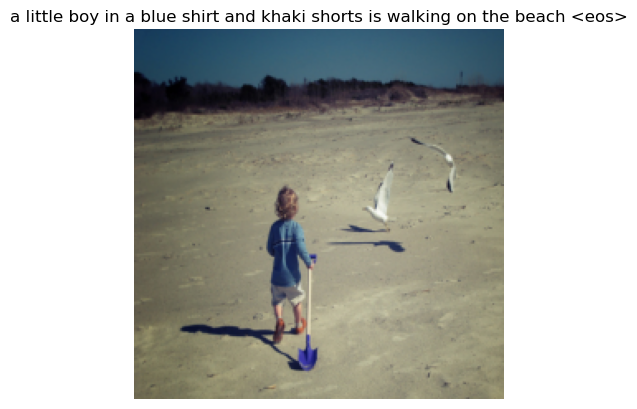

Epoch 11/100 - Train Loss: 2.2890, Val Loss: 2.7606, BLEU: 0.0812, ROUGE-1 Precision: 0.4060, ROUGE-1 Recall: 0.3781, ROUGE-1 F1: 0.3733, ROUGE-2 Precision: 0.1513, ROUGE-2 Recall: 0.1396, ROUGE-2 F1: 0.1378, ROUGE-L Precision: 0.3713, ROUGE-L Recall: 0.3484, ROUGE-L F1: 0.3427
Saved checkpoint for epoch 11 at saved_model\LSTM_without_Attention_resnet50_None_epoch_11.pth.gz
Epoch: 12, Batch: 400, Training Loss: 2.30368


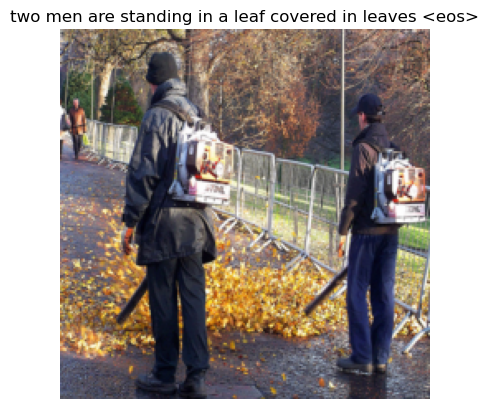

Epoch 12/100 - Train Loss: 2.2418, Val Loss: 2.7539, BLEU: 0.0831, ROUGE-1 Precision: 0.4051, ROUGE-1 Recall: 0.3811, ROUGE-1 F1: 0.3752, ROUGE-2 Precision: 0.1497, ROUGE-2 Recall: 0.1399, ROUGE-2 F1: 0.1377, ROUGE-L Precision: 0.3699, ROUGE-L Recall: 0.3508, ROUGE-L F1: 0.3441
Saved checkpoint for epoch 12 at saved_model\LSTM_without_Attention_resnet50_None_epoch_12.pth.gz
Epoch: 13, Batch: 400, Training Loss: 2.19786


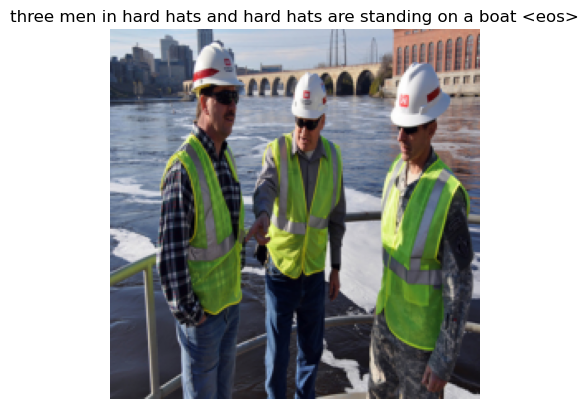

Epoch 13/100 - Train Loss: 2.1984, Val Loss: 2.7543, BLEU: 0.0871, ROUGE-1 Precision: 0.3998, ROUGE-1 Recall: 0.3881, ROUGE-1 F1: 0.3758, ROUGE-2 Precision: 0.1507, ROUGE-2 Recall: 0.1443, ROUGE-2 F1: 0.1401, ROUGE-L Precision: 0.3643, ROUGE-L Recall: 0.3561, ROUGE-L F1: 0.3436
Saved checkpoint for epoch 13 at saved_model\LSTM_without_Attention_resnet50_None_epoch_13.pth.gz
Epoch: 14, Batch: 400, Training Loss: 2.15304


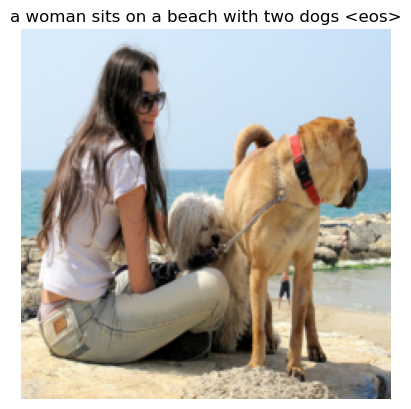

Epoch 14/100 - Train Loss: 2.1564, Val Loss: 2.7551, BLEU: 0.0839, ROUGE-1 Precision: 0.4160, ROUGE-1 Recall: 0.3785, ROUGE-1 F1: 0.3786, ROUGE-2 Precision: 0.1562, ROUGE-2 Recall: 0.1396, ROUGE-2 F1: 0.1402, ROUGE-L Precision: 0.3804, ROUGE-L Recall: 0.3484, ROUGE-L F1: 0.3474
Saved checkpoint for epoch 14 at saved_model\LSTM_without_Attention_resnet50_None_epoch_14.pth.gz
Epoch: 15, Batch: 400, Training Loss: 2.12700


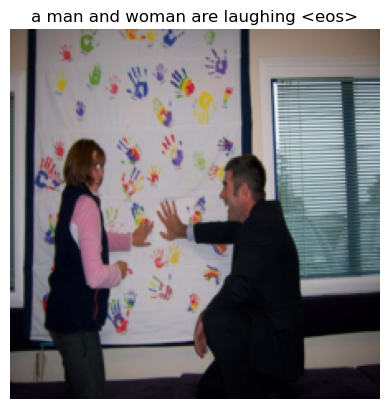

Epoch 15/100 - Train Loss: 2.1184, Val Loss: 2.7624, BLEU: 0.0845, ROUGE-1 Precision: 0.4116, ROUGE-1 Recall: 0.3788, ROUGE-1 F1: 0.3766, ROUGE-2 Precision: 0.1544, ROUGE-2 Recall: 0.1408, ROUGE-2 F1: 0.1400, ROUGE-L Precision: 0.3756, ROUGE-L Recall: 0.3484, ROUGE-L F1: 0.3451
Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.
Saved checkpoint for epoch 15 at saved_model\LSTM_without_Attention_resnet50_None_epoch_15.pth.gz
Epoch: 16, Batch: 400, Training Loss: 1.95318


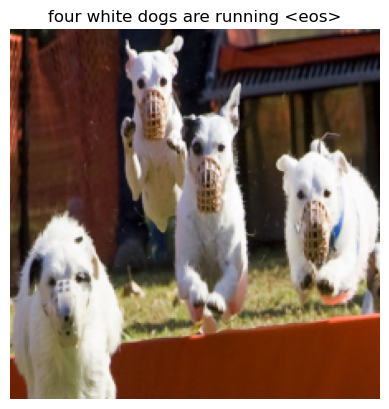

In [ ]:
from src.utils import train_model

train_model(
    model=model_NoAttention,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    vocab=vocab,
    vocab_builder=vocab_builder,
    num_epochs=num_epochs,
    print_every=print_every,
    early_stopping=early_stopping,
    save_dir=save_dir,
    device=device,
    Transform_mean=mean,
    Transform_std=std,
    model_name="LSTM_without_Attention",
    max_sentence_length=max_sentence_length,
    encoder_backbone=backbone,
    transformation_type=transformation
)
